In [1]:
import pandas as pd

In [67]:
elc = pd.read_csv('datasets/ETTm2.csv')

In [2]:
import matplotlib.pyplot as plt

In [69]:
elc.shape

(69680, 8)

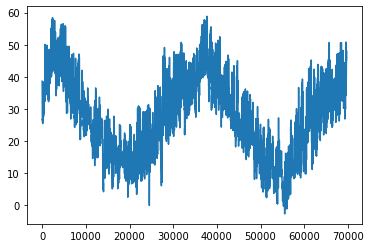

In [5]:
plt.plot(elc.OT)

In [197]:
from torch.utils.data import DataLoader

In [198]:
from typing import List

import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset


class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"


class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5


class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5


class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5


class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5


class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5


class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5


class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5


class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5


def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)


def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [199]:
import os
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import warnings

In [202]:


class Dataset_Custom(Dataset):
    def __init__(self, flag='train', size=[192, 48, 96],
                 features='S',
                 target='OT', scale=True, timeenc=0, freq='h'):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv('datasets/ETTm2.csv')

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        cols = list(df_raw.columns)
        cols.remove(self.target)
        cols.remove('date')
        df_raw = df_raw[['date'] + cols + [self.target]]
        # print(cols)
        num_train = int(len(df_raw) * 0.7)
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)
    


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

In [299]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import math

def compared_version(ver1, ver2):
    """
    :param ver1
    :param ver2
    :return: ver1< = >ver2 False/True
    """
    list1 = str(ver1).split(".")
    list2 = str(ver2).split(".")
    
    for i in range(len(list1)) if len(list1) < len(list2) else range(len(list2)):
        if int(list1[i]) == int(list2[i]):
            pass
        elif int(list1[i]) < int(list2[i]):
            return -1
        else:
            return 1
    
    if len(list1) == len(list2):
        return True
    elif len(list1) < len(list2):
        return False
    else:
        return True

class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if compared_version(torch.__version__, '1.5.0') else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()

        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6, 'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='timeF', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)


class DataEmbedding_wo_pos(nn.Module):
    def __init__(self, c_in, d_model, embed_type='timeF', freq='h', dropout=0.1):
        super(DataEmbedding_wo_pos, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.temporal_embedding(x_mark)
        return self.dropout(x)

In [300]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class my_Layernorm(nn.Module):
    """
    Special designed layernorm for the seasonal part
    """
    def __init__(self, channels):
        super(my_Layernorm, self).__init__()
        self.layernorm = nn.LayerNorm(channels)

    def forward(self, x):
        x_hat = self.layernorm(x)
        bias = torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1)
        return x_hat - bias


class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean


class EncoderLayer(nn.Module):
    """
    Autoformer encoder layer with the progressive decomposition architecture
    """
    def __init__(self, attention, d_model, d_ff=None, moving_avg=25, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False)
        self.decomp1 = series_decomp(moving_avg)
        self.decomp2 = series_decomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)
        x, _ = self.decomp1(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        res, _ = self.decomp2(x + y)
        return res, attn


class Encoder(nn.Module):
    """
    Autoformer encoder
    """
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns


class DecoderLayer(nn.Module):
    """
    Autoformer decoder layer with the progressive decomposition architecture
    """
    def __init__(self, self_attention, cross_attention, d_model, c_out, d_ff=None,
                 moving_avg=25, dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False)
        self.decomp1 = series_decomp(moving_avg)
        self.decomp2 = series_decomp(moving_avg)
        self.decomp3 = series_decomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=3, stride=1, padding=1,
                                    padding_mode='circular', bias=False)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x, trend1 = self.decomp1(x)
        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])
        x, trend2 = self.decomp2(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        x, trend3 = self.decomp3(x + y)

        residual_trend = trend1 + trend2 + trend3
        residual_trend = self.projection(residual_trend.permute(0, 2, 1)).transpose(1, 2)
        return x, residual_trend


class Decoder(nn.Module):
    """
    Autoformer encoder
    """
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, trend=None):
        for layer in self.layers:
            x, residual_trend = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)
            trend = trend + residual_trend

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x, trend

In [301]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
from math import sqrt
import os


class AutoCorrelation(nn.Module):
    """
    AutoCorrelation Mechanism with the following two phases:
    (1) period-based dependencies discovery
    (2) time delay aggregation
    This block can replace the self-attention family mechanism seamlessly.
    """
    def __init__(self, mask_flag=True, factor=1, scale=None, attention_dropout=0.1, output_attention=False):
        super(AutoCorrelation, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def time_delay_agg_training(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the training phase.
        """
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        index = torch.topk(torch.mean(mean_value, dim=0), top_k, dim=-1)[1]
        weights = torch.stack([mean_value[:, index[i]] for i in range(top_k)], dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            pattern = torch.roll(tmp_values, -int(index[i]), -1)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_inference(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the inference phase.
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0)\
            .repeat(batch, head, channel, 1).to(values.device)
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        weights, delay = torch.topk(mean_value, top_k, dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            tmp_delay = init_index + delay[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_full(self, values, corr):
        """
        Standard version of Autocorrelation
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0)\
            .repeat(batch, head, channel, 1).to(values.device)
        # find top k
        top_k = int(self.factor * math.log(length))
        weights, delay = torch.topk(corr, top_k, dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            tmp_delay = init_index + delay[..., i].unsqueeze(-1)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * (tmp_corr[..., i].unsqueeze(-1))
        return delays_agg

    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        if L > S:
            zeros = torch.zeros_like(queries[:, :(L - S), :]).float()
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
        else:
            values = values[:, :L, :, :]
            keys = keys[:, :L, :, :]

        # period-based dependencies
        q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, dim=-1)

        # time delay agg
        if self.training:
            V = self.time_delay_agg_training(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)
        else:
            V = self.time_delay_agg_inference(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)

        if self.output_attention:
            return (V.contiguous(), corr.permute(0, 3, 1, 2))
        else:
            return (V.contiguous(), None)


class AutoCorrelationLayer(nn.Module):
    def __init__(self, correlation, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AutoCorrelationLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_correlation = correlation
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_correlation(
            queries,
            keys,
            values,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

In [304]:
# Univaraite case
#   --features S \
#   --seq_len 96 \
#   --label_len 96 \
#   --pred_len 192 \
#   --e_layers 2 \
#   --d_layers 1 \
#   --factor 3 \
#   --enc_in 1 \
#   --dec_in 1 \
#   --c_out 1 \
#   --des 'Exp' \
#   --itr 1 \
#   --freq 't' \
#   --train_epochs 1

In [305]:

class Model(nn.Module):
    """
    Autoformer is the first method to achieve the series-wise connection,
    with inherent O(LlogL) complexity
    """
    def __init__(self):
        super(Model, self).__init__()
        self.seq_len = 96
        self.label_len = 96
        self.pred_len = 192
        self.output_attention = True

        # Decomp
        self.e_layers = 2
        self.d_layers = 1
        self.factor = 3
        self.kernel_size = 25
        self.moving_avg  = 25
        self.activation = 'gelu'
        self.decomp = series_decomp(self.kernel_size)
        self.dropout = 0.05
        self.enc_in = 1
        self.dec_in = 1
        self.freq = 't'
        self.embed = 'timeF'
        self.d_model = 512
        self.n_heads = 8
        self.c_out = 1
        self.d_ff = 2048
#         self.decomp = series_decomp(kernel_size)

        # Embedding
        # The series-wise connection inherently contains the sequential information.
        # Thus, we can discard the position embedding of transformers.
        self.enc_embedding = DataEmbedding_wo_pos(self.enc_in, self.d_model, self.embed, self.freq,
                                                  self.dropout)
        self.dec_embedding = DataEmbedding_wo_pos(self.dec_in, self.d_model, self.embed, self.freq,
                                                  self.dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(False, self.factor, attention_dropout=self.dropout,
                                        output_attention=self.output_attention),
                        self.d_model, self.n_heads),
                    self.d_model,
                    self.d_ff,
                    moving_avg=self.moving_avg,
                    dropout=self.dropout,
                    activation=self.activation
                ) for l in range(self.e_layers)
            ],
            norm_layer=my_Layernorm(self.d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(True, self.factor, attention_dropout=self.dropout,
                                        output_attention=False),
                        self.d_model, self.n_heads),
                    AutoCorrelationLayer(
                        AutoCorrelation(False, self.factor, attention_dropout=self.dropout,
                                        output_attention=False),
                        self.d_model, self.n_heads),
                    self.d_model,
                    self.c_out,
                    self.d_ff,
                    moving_avg=self.moving_avg,
                    dropout=self.dropout,
                    activation=self.activation,
                )
                for l in range(self.d_layers)
            ],
            norm_layer=my_Layernorm(self.d_model),
            projection=nn.Linear(self.d_model, self.c_out, bias=True)
        )

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        # decomp init
        mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, self.pred_len, 1)
        zeros = torch.zeros([x_dec.shape[0], self.pred_len, x_dec.shape[2]], device=x_enc.device)
        seasonal_init, trend_init = self.decomp(x_enc)
        # decoder input
        trend_init = torch.cat([trend_init[:, -self.label_len:, :], mean], dim=1)
        seasonal_init = torch.cat([seasonal_init[:, -self.label_len:, :], zeros], dim=1)
        # enc
        enc_out = self.enc_embedding(x_enc.float(), x_mark_enc.float())
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)
        # dec
        dec_out = self.dec_embedding(seasonal_init.float(), x_mark_dec.float())
        seasonal_part, trend_part = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask,
                                                 trend=trend_init)
        # final
        dec_out = trend_part + seasonal_part

        if self.output_attention:
            return dec_out[:, -self.pred_len:, :], attns
        else:
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]

In [306]:
ED = elc

    
ED['d'] = pd.to_datetime(ED['date'])
ED['Year'] = ED['date'].apply(lambda x: int(x[:10][:4]))
ED['month'] = ED['date'].apply(lambda x: int(x[:10][5:7]))
ED['hr'] = ED['date'].apply(lambda x: int(x[11:][:2]))
ED['min'] = ED['date'].apply(lambda x: int(x[11:][3:5]))
ED['day'] = ED.d.apply(lambda row: row.day, 1)
ED['weekday'] = ED.d.apply(lambda row: row.weekday(), 1)

ED['t'] = ED['Year'] + ((ED['month'] - 1)/ 12) + ((ED['day'] - 1)/ (12 *31) + ED['hr']/(24*31*12) + ED['min']/(60*24*31*12))
t = np.array(ED['t'])
ED_13 = (ED.loc[ED.t >= 2013, :])

client_w_time = (ED.loc[ED.t >= 2013, ['Year', 'month', 'day', 'weekday', 'hr','min', 'OT']])
time_feat = ED.loc[ED.t >= 2013, ['Year', 'month', 'day', 'weekday', 'hr','min']]


t_13 = ED_13.index
train_last_ix = int(len(t_13) *0.8)
# target = ED_13.loc[:, ['HUFL','HULL','LUFL','LULL','MUFL', 'MULL', 'OT']]
target = ED_13.loc[:, ['OT']]
arr_kwh = target 
μ_arr =  np.mean(arr_kwh[:train_last_ix], axis=0)
σ_arr =  np.std(arr_kwh[:train_last_ix], axis=0)
arr_kwh_a = np.array((arr_kwh - μ_arr)/σ_arr)
# time_features = client_w_time.iloc[:, 1:6]
time_features = client_w_time.iloc[:, 1:6]

In [322]:
training_data_target = arr_kwh_a[:int(0.7*arr_kwh_a.shape[0])]
val_data_target = arr_kwh_a[int(0.7*arr_kwh_a.shape[0]):int(0.8*arr_kwh_a.shape[0])]
test_data_target = arr_kwh_a[int(0.8*arr_kwh_a.shape[0]):]


training_data_time = time_features.iloc[:int(0.7*arr_kwh_a.shape[0]), :]
val_data_time = time_features.iloc[int(0.7*arr_kwh_a.shape[0]):int(0.8*arr_kwh_a.shape[0]), :]
test_data_time = time_features.iloc[int(0.8*arr_kwh_a.shape[0]):, :]

In [323]:
def batcher(time_features, target, batch_s = 32, training=True, tar_dim = 1):
    enc_l = 96
    dec_l = 192
    win_l = enc_l + dec_l
    idx = np.random.choice(np.arange(win_l, len(target) - win_l), batch_s)
    tar = np.array([target[i:i+win_l] for i in idx])
    t = np.array([np.array(time_features)[i:i+win_l, :] for i in idx])    
    x_enc = tar[:, :enc_l].reshape(batch_s, enc_l, tar_dim); 
    x_dec = tar[:, :win_l].reshape(batch_s, win_l, tar_dim)
    
    y_tar = x_dec[:, -192:, :].copy()
    x_dec[:, -192:, :] = 0
    
    x_mark_enc = t[:, :enc_l, :]; 
    x_mark_dec = t[:, :win_l, :]
    
    return x_enc, x_dec, x_mark_enc, x_mark_dec, y_tar

In [325]:
from torch import optim
import time

In [326]:
import IPython

In [327]:
best_models = []
for j in range(5):
    mini = 5000
    model = Model()
    model_optim = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()
    iter_count = 0
    epoch_time = time.time()
    train_loss = []
    val_loss = []
    for i in range(40000):
        print(i)
        
        model.train()
        batch_x, batch_y, batch_x_mark, batch_y_mark, y_tar = batcher(np.array(training_data_time), training_data_target) 
        iter_count += 1
        model_optim.zero_grad()
        # decoder input
        outputs = model(torch.tensor(batch_x), torch.tensor(batch_x_mark), torch.tensor(y_tar), torch.tensor(batch_y_mark))

        outputs = outputs[0][:, -192:, 0]
        batch_y = torch.tensor(y_tar[:, -192:, 0])
        loss = criterion(outputs, batch_y)
        train_loss.append(loss.item())




        loss.backward()
        model_optim.step()
        if (i + 1) % 500 == 0:
            # evaluate model:
            model.eval()

            with torch.no_grad():
                batch_x, batch_y, batch_x_mark, batch_y_mark, y_tar = batcher(np.array(val_data_time), val_data_target, batch_s=100, training=False) 
                out_data = model(torch.tensor(batch_x), torch.tensor(batch_x_mark), torch.tensor(y_tar), torch.tensor(batch_y_mark))
                out_data = out_data[0][:, -192:, 0]
                batch_y = torch.tensor(y_tar[:, -192:, 0])
                loss_v = criterion(out_data, batch_y)
                val_loss.append(loss_v.item())
                IPython.display.clear_output(wait=True)
                plt.plot(train_loss, label = 'train mse')
                plt.plot(val_loss, label= 'validation mse')
                plt.show()
                if loss_v < mini:
                    mini = loss_v
                    torch.save(model.state_dict(), 'weights/forecasting/ETT/autoformer/96_context_192_pred/192_out_best-model-parameters_{}.pt'.format(j)) # official recommended

            print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, i + 1, loss.item()))
            print("\titers: {0}, epoch: {1} | loss val: {2:.7f}".format(i + 1, i + 1, loss_v.item()))
            print("iter: {} cost time: {}".format(iter_count + 1, time.time() - epoch_time))
            epoch_time = time.time()
    
    best_models.append(np.min(val_loss))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


KeyboardInterrupt: 

In [328]:
param_size=0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()

In [329]:
param_size

42024964

In [15]:
merged = np.load('merged_192_out_96_input.npy')

In [16]:
x_all = np.load('x_all_test_set_electricity_192_out.npy')

In [17]:
96+192

288

In [18]:
rows_to_delete = np.array([33, 46, 54, 71, 82, 105, 166, 188, 200, 201, 218, 229, 269, 289, 302, 330, 429, 450, 491, 492, 495, 498, 519, 521, 549, 561, 595, 602, 613, 619, 622, 663, 678, 708, 725, 745, 817, 866, 868, 870, 890, 911, 916, 925, 926, 945, 974,
891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 912, 913, 914, 915, 917, 918, 919, 920, 921, 922, 923, 924, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999])

In [19]:
merged = np.delete(merged, rows_to_delete, axis=0)
x_all = np.delete(x_all, rows_to_delete, axis=0)

In [20]:
enc_l = 96
win_l = 288
batch_s = 850

In [21]:

    x_enc = merged[:, :enc_l, :].reshape(batch_s, enc_l, 1); 

    x_dec = merged[:, :win_l, :].reshape(batch_s, win_l, 1)
    y_tar = merged[:, -192:, :].copy()
    x_dec[:, -192:, :] = 0
    
    x_mark_enc = x_all[:, :enc_l, :]; 
    x_mark_dec = x_all[:, :win_l, :]

In [22]:
criterion = nn.MSELoss()
import math as ma 

In [1]:
def seq_lik(y, ŷ, log_σ, ϵ=0.001):
    pi = torch.tensor(ma.pi)
    mse_per_point = torch.square(torch.subtract(y, ŷ))
    lik_per_point = (-1 / 2) * (torch.divide(mse_per_point, torch.square(torch.exp(log_σ)) + ϵ)) - 1*torch.log(torch.exp(log_σ) + ϵ)- (1/2)*torch.log(2*pi)
    return lik_per_point

In [2]:
mse_test_loss = []
like_test_loss = []
for i in range(5):
    model = Model() # we do not specify pretrained=True, i.e. do not load default weights
    model.load_state_dict(torch.load('192_out_best-model-parameters_{}.pt'.format(i)))
    model.eval()
    
    
    test_batch_s = 100 #need to specify this as it gets changed in the loop below
    idx_list = list(range(test_data_time.shape[0] - (192)))
    num_batches = len(idx_list)//test_batch_s

    for _ in range(num_batches): #### specify correct number of batches for the batcher #####
        if(_ == (num_batches-1)): test_batch_s = len(idx_list)        
        batch_x, batch_y, batch_x_mark, batch_y_mark, y_tar = batcher_test(np.array(test_data_time), test_data_target, batch_s=100, training=False) 
        outputs_te = model(torch.tensor(x_enc), torch.tensor(x_mark_enc), torch.tensor(y_tar), torch.tensor(x_mark_dec))
        batch_y = torch.tensor(y_tar)
        loss = criterion(outputs_te[0], batch_y)
        
        _, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
        sum_nll_tot += sum_nll / n_T
        sum_mse_tot += sum_mse / n_T

    nllx =  sum_nll_tot / (test_batch_s * x_test.shape[0]//test_batch_s)
    msex =  sum_mse_tot / (test_batch_s * x_test.shape[0]//test_batch_s)


    nll_list.append(nllx.numpy())
    mse_list.append(msex.numpy())
                
            
    np.save(save_dir + '/nll_list.npy', nll_list)    
    np.save(save_dir + '/mse_list.npy', mse_list)  

    mse_test_loss.append(loss.detach().numpy())
    log_σ = np.log(np.sqrt(mse_test_loss[-1]))
    lik_pp = seq_lik(batch_y, outputs_te[0], torch.tensor(log_σ))
    like_test_loss.append(np.mean(lik_pp.detach().numpy()))
print(np.mean(mse_test_loss))
print(np.std(mse_test_loss))
print(np.mean(like_test_loss))
print(np.std(like_test_loss))

NameError: name 'Model' is not defined

In [3]:
import tensorflow as tf

In [4]:
import numpy as np

In [3]:
a = np.array([[1., 5., 7., 12.], [63., 15., 52., 172.]])

In [4]:
b = a

In [5]:
a.shape

(2, 4)

In [6]:
tf.transpose(tf.random.shuffle(tf.transpose(a, perm=[1, 0])), perm =[1, 0]) 

Metal device set to: Apple M1 Max


2023-05-07 09:56:17.748194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-07 09:56:17.748356: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[ 12.,   7.,   1.,   5.],
       [172.,  52.,  63.,  15.]])>

In [7]:
from data_wrangler import feature_extractor

In [8]:
f  =feature_extractor.feature_wrapper()

In [9]:
tf.constant(2, dtype=tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [10]:
f.permute([tf.constant(a, dtype=tf.float32), tf.constant(b, dtype=tf.float32), tf.constant(2, dtype=tf.int32), tf.constant(2, dtype=tf.int32), tf.constant(2, dtype=tf.int32)])




InvalidArgumentError: Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

In [ ]:
from comparison_models.gru import gru_pipeline

In [11]:
g1 =  gru_pipeline.gru_pipeline([10], 2, 1)

NameError: name 'gru_pipeline' is not defined

In [12]:
from data_wrangler import dataset_preparer

In [13]:
        x_train, y_train, x_val, y_val, x_test, y_test = dataset_preparer.weather_processor(path_to_weather_data="datasets/weather.csv") 


In [14]:
from data_wrangler import batcher

In [15]:
n_C = 10
n_T = 10

In [16]:
            idx_list = list(range(x_train.shape[0] - (n_C+n_T)))


In [17]:
x,y,_ = batcher.batcher(x_train,y_train,idx_list,window=n_C+n_T) ####### generalise for not just forecasting


In [18]:
x.shape

(32, 20, 1)

In [19]:
a, b = f.permute([x,y, 10, 10, 2])

In [20]:
b[0 , :, 0]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.45411626, 0.46649173, 0.45411626, 0.39687976, 0.40770826,
       0.45102248, 0.46958566, 0.50516504, 0.5330099 , 0.5438383 ,
       0.6644992 , 0.5639485 , 0.5670424 , 0.6644992 , 0.56549543,
       0.67223376, 0.6119035 , 0.68770313, 0.63974816, 0.5902464 ],
      dtype=float32)>

In [21]:
b[32, : , 0]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.45411626, 0.46649173, 0.45411626, 0.39687976, 0.40770826,
       0.45102248, 0.46958566, 0.50516504, 0.5330099 , 0.5438383 ,
       0.6119035 , 0.5902464 , 0.63974816, 0.56549543, 0.5639485 ,
       0.5670424 , 0.68770313, 0.6644992 , 0.6644992 , 0.67223376],
      dtype=float32)>

In [17]:
a[0, : ,:]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.01103164],
       [0.01750057],
       [0.01374215],
       [0.01171413],
       [0.01860397],
       [0.02116016],
       [0.01885492],
       [0.02241357],
       [0.02199049],
       [0.01917847]], dtype=float32)>

In [11]:
a[32, : ,:]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[-0.2153583 ],
       [-0.20701684],
       [-0.2052439 ],
       [-0.20571813],
       [-0.21017832],
       [-0.20565562],
       [-0.21185149],
       [-0.20508847],
       [-0.20309193],
       [-0.20570324]], dtype=float32)>

In [51]:
n_C =10
n_T =15
batch_size=32

In [59]:
        x_mask = tf.linalg.band_part(tf.ones((n_T, n_C + n_T), tf.bool), -1, n_C)
        x_mask_inv = (x_mask == False)
        x_mask_float = tf.cast(x_mask_inv, "float32")*1000
        x_mask_float_repeat = tf.repeat(x_mask_float[tf.newaxis, :], axis=0, repeats=batch_size)

In [55]:
        x_mask = 1000  * (tf.constant(1, tf.int32) -  tf.linalg.band_part(tf.ones((n_T, n_C + n_T), tf.int32), -1, n_C))


In [60]:
x_mask_float.numpy()

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000.],


In [30]:
x_mask.numpy()

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,
        False, False],
       [ T

In [28]:
x_mask_float_repeat

<tf.Tensor: shape=(32, 10, 20), dtype=float32, numpy=
array([[[   0.,    0.,    0., ..., 1000., 1000., 1000.],
        [   0.,    0.,    0., ..., 1000., 1000., 1000.],
        [   0.,    0.,    0., ..., 1000., 1000., 1000.],
        ...,
        [   0.,    0.,    0., ...,    0., 1000., 1000.],
        [   0.,    0.,    0., ...,    0.,    0., 1000.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[   0.,    0.,    0., ..., 1000., 1000., 1000.],
        [   0.,    0.,    0., ..., 1000., 1000., 1000.],
        [   0.,    0.,    0., ..., 1000., 1000., 1000.],
        ...,
        [   0.,    0.,    0., ...,    0., 1000., 1000.],
        [   0.,    0.,    0., ...,    0.,    0., 1000.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[   0.,    0.,    0., ..., 1000., 1000., 1000.],
        [   0.,    0.,    0., ..., 1000., 1000., 1000.],
        [   0.,    0.,    0., ..., 1000., 1000., 1000.],
        ...,
        [   0.,    0.,    0., ...,    0., 1000.,

In [27]:
x_mask_float

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0., 1000., 1000., 1000., 1000.,
        1000., 1000.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0., 1000., 1000., 1000.,
        1000., 1000.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0

In [25]:
x_mask

<tf.Tensor: shape=(10, 20), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, 

In [14]:
    mask = np.tri(n_C + n_T, n_C + n_T, 0) - np.eye(n_C + n_T)
    mask[:n_C, :n_C] = 1 


In [ ]:
#### TNP mask

In [32]:
np.tri(n_C + n_T, n_C + n_T, 0)

array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]])

In [34]:
a = np.random.normal(size=(5, 5))

In [40]:
tf.linalg.band_part(tf.ones([n_C + n_T, n_C + n_T]), -1, 0) 

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

In [30]:
    mask_a = tf.tri(n_C + n_T, n_C + n_T, 0) - tf.eye(n_C + n_T)
    mask_a[:n_C, :n_C] = 1 

AttributeError: module 'tensorflow' has no attribute 'tri'

In [29]:
tf.concat([mask_a , mask_a], axis=0)

<tf.Tensor: shape=(10, 5), dtype=float64, numpy=
array([[1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.]])>

In [17]:
        context_part = tf.concat([tf.ones((n_C,n_C),tf.bool),tf.zeros((n_C,2*n_T),tf.bool)],
                         axis=-1)
        first_part = tf.linalg.band_part(tf.ones((n_T,n_C+2*n_T),tf.bool),-1,n_C)
        second_part = tf.linalg.band_part(tf.ones((n_T,n_C+2*n_T),tf.bool),-1,n_C-1)
        mask = tf.concat([context_part,first_part,second_part],axis=0)

In [18]:
mask

<tf.Tensor: shape=(8, 8), dtype=bool, numpy=
array([[ True,  True, False, False, False, False, False, False],
       [ True,  True, False, False, False, False, False, False],
       [ True,  True,  True, False, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True,  True, False, False, False],
       [ True,  True, False, False, False, False, False, False],
       [ True,  True,  True, False, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False]])>

In [ ]:
######

In [16]:
mask

array([[[1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]],

       [[1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]],

       [[1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]],

       [[1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]],

       [[1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]],

       [[1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]],

       [[1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.]

In [64]:
        y_temp = tf.squeeze(y[:, :n_C])
        y_temp = tf.repeat(tf.expand_dims(y_temp,  axis=1),  axis=1,  repeats=n_C)

In [65]:
y_temp.shape

TensorShape([32, 10, 10, 1])

In [10]:
n_C = 2
n_T = 3

In [11]:
        context_part = tf.concat([tf.ones((n_C,n_C),tf.bool),tf.zeros((n_C,n_T),tf.bool)],axis=-1)
        diagonal_mask = tf.linalg.band_part(tf.ones((n_C+n_T,n_C+n_T),tf.bool),-1,0)
        lower_diagonal_mask = tf.linalg.set_diag(diagonal_mask,tf.zeros(diagonal_mask.shape[0:-1],tf.bool)) ### condense into one line?                                                                               
        mask = tf.concat([context_part,lower_diagonal_mask[n_C:n_C+n_T,:n_C+n_T]],axis=0) # check no conflicts with init and check mask is correct shape

In [12]:
mask

<tf.Tensor: shape=(5, 5), dtype=bool, numpy=
array([[ True,  True, False, False, False],
       [ True,  True, False, False, False],
       [ True,  True, False, False, False],
       [ True,  True,  True, False, False],
       [ True,  True,  True,  True, False]])>